In [160]:
from AFEP_parse import *
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import warnings #Suppress future warnings from pandas.
warnings.simplefilter(action='ignore', category=FutureWarning)

# How to Use this Notebook:

## User Parameters:
The notebook as-is will read and process the sample outputs provided.

- root should be the path (relative or absolute) to the parent directory that contains (or will containt) all your data.
- temperature is the temperature **at which your simulations were run** 
- decorrelate is a flag for automatic decorrelation of samples (see Shirts and Chodera '08). Should be set to True for general use. 
- detectEQ (automatic equilibrium detection) flag is optional. If you have very poor convergence but believe your system is well-sampled, you may wish to try it.

## Layout:
The notebook is organized into five sections (separated by horizontal lines):
- Process the Bound Data (step 2.2)
- Process the Unbound Data (step 2.4)
- Process the DBC TI calculation (step 2.3)
- Calculate the Volumetric Restraint Contribution
- Calculate the Binding Free Energy
Each section starts with a variable block including a path variable (set relative to the root). This may need to be updated if you use a different file structure from that used in the sample data.

## File Structure of Sample Data:
```
Repository/Supp-Files
|
|----AFEP-Bound-Decoupling
|    |----output
|         | *.fepout
|
|----AFEP-Bulk
|    |----output
|         | *fepout
|
|----DBC_TI
|    |----output
|         | *.colvars.traj
|
|
```



# Other Important Notes and Credits
- This notebook is specially written for the SAFEP tutorial. 
For more up-to-date and general versions see the SAFEP github.

- This and other SAFEP notebooks make use of pyMBAR and Alchemlyb. 
For more information see Shirts and Chodera (2008), "Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177



In [161]:
root = '..' #Root path to fepout files

temperature = 300
radius = 3 #Radius of the spherical restraint used for the DBC TI calculation
DBC_wall = 1.5 #Position of the DBC upper wall

decorrelate = True #Flag for automatic decorrelation
detectEQ = False #Flag for automatic equilibrium detection
RT = 0.00198720650096 * temperature # RT in kcal/mol

***
# Process the Bound FEP Data 
Here we process the FEP data generated by decoupling the ligand from the protein (**Step 2.2**)

In [174]:
path=f'{root}/AFEP-Bound-Decoupling/output/' #Path to fepout files
filename='*.fepout' #This can be a regex pattern if you have more than one fepout file
#Caution: if you have multiple fepout files, name them alphanumerically

In [175]:
fepoutFiles = glob(path+filename) #Resolve any naming regular expressions
u_nk, _ = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ) #u_nk stores the fep data
perWindow, cumulative = doEstimation(u_nk) #Run the BAR estimator on the fep data
forward, forward_error, backward, backward_error = doConvergence(u_nk) #Used later in the convergence plot

dG_site = np.round(cumulative.BAR.f.iloc[-1]*RT, 1)
error_site = np.round(cumulative.BAR.errors.iloc[-1]*RT, 1)
changeAndError = f'\u0394G<sub>site</sub> = {dG_site}\u00B1{error_site} kcal/mol'
Markdown('<font size=5>{}</font><br/>'.format(changeAndError))

Decorrelating samples. Flag='True'


<font size=5>ΔG<sub>site</sub> = 14.9±0.1 kcal/mol</font><br/>

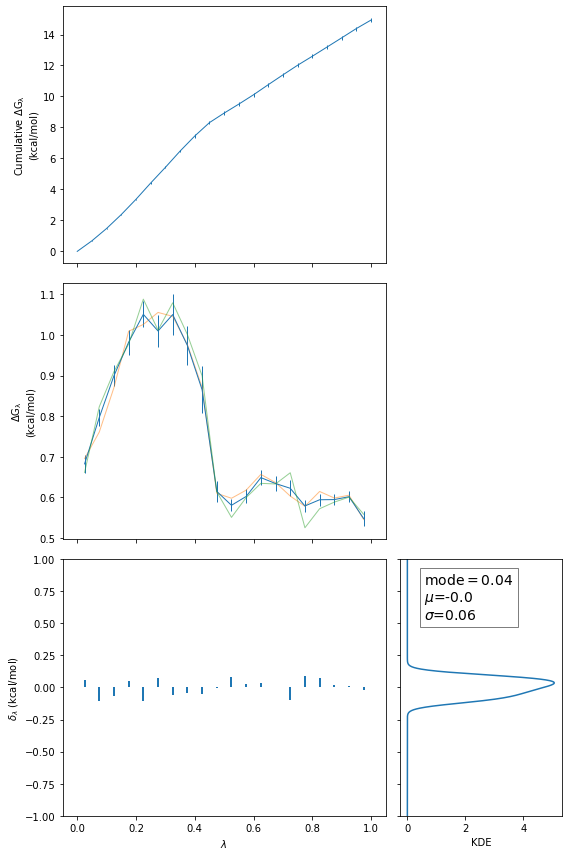

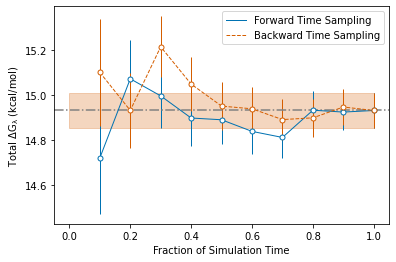

In [176]:
#Make some general plots
width = 8
height = 4
fig, axes = plotGeneral(cumulative, perWindow, RT, width=width, height=height, PDFtype='KDE')
plt.savefig(f'{path}/bound_generalFigures.svg')
plt.show()

fig, convAx = plt.subplots(1,1)
convAx = convergencePlot(convAx, forward*RT, forward_error*RT, backward*RT, backward_error*RT)

fig.set_figwidth(width*3/4)
fig.set_figheight(height)

plt.savefig(f'{path}/bound_convergence.svg')
plt.show()

***
# Process the DBC TI calculation
Free energy cost of imposing the DBC (**Step 2.3**)

Note: The error estimate below is just the standard deviation of the samples. <br>
The BAR errors calculated above are standard errors of the mean.

In [165]:
from TI_Calculations import *

In [166]:
path = f'{root}/DBC_TI/output/'
dataTI = pd.read_csv(glob(path+'*.colvars.traj')[0], delim_whitespace=True, names=['step','DBC', 'distance', 'E_dist', 'E_DBC'], comment='#', index_col=0)
dataTI = dataTI[dataTI.index>=1000][1:]
dataTI.index = dataTI.index-1000

#For comparison to current method. Not needed in release form.
#RFEPdat = pd.read_csv(glob(path+'RFEP.dat')[0], delim_whitespace=True, names=['L', 'dGperL'], comment='#', index_col=0)

nLambdas = 41
Lsched = np.linspace(1,0,nLambdas)

Dist = makeHarmonicWall(FC=200, upperWalls=radius, name='Dist_rest')
DBC = makeHarmonicWall(FC=0, targetFC=200, targetFE=6, upperWalls=DBC_wall, targetEQ=500, numSteps=300000, name='DBC_rest', schedule=Lsched)
Ls = (dataTI.index.values-1)//DBC['numSteps']
Ls[0] = 0
Ls[Ls==41] = 40 #Fix in case there are extra samples for the last window

In [167]:
dataLs = np.round([DBC['schedule'][i] for i in Ls], 3)
dataTI.loc[:,'L'] = dataLs
dataTI = dataTI.iloc[1:]

In [168]:
dUs = {}
for key, group in dataTI.groupby('L'):
    dUs[key] = [HW_dUdL(DBC, coord, key) for coord in group.DBC]

Lsched = np.sort(list(dUs.keys()))
dL = Lsched[1] - Lsched[0]
TIperWindow = pd.DataFrame(index=Lsched)
TIperWindow['dGdL'] = [np.mean(dUs[L])*dL for L in Lsched]
TIperWindow['error'] = [np.std(dUs[L])*dL for L in Lsched]

TIcumulative = pd.DataFrame()
TIcumulative['dG'] = np.cumsum(TIperWindow.dGdL)
TIcumulative['error'] = np.sqrt(np.divide(np.cumsum(TIperWindow.error**2), np.arange(1,len(TIperWindow)+1)))

In [169]:
dG_DBC = np.round(TIcumulative['dG'][1], 1)
error_DBC = np.round(TIcumulative['error'][1], 1)
changeAndError = f'\u0394G<sub>DBC</sub> = {dG_DBC}\u00B1{error_DBC} kcal/mol'
Markdown('<font size=5>{}</font><br/>'.format(changeAndError))

<font size=5>ΔG<sub>DBC</sub> = 3.9±0.1 kcal/mol</font><br/>

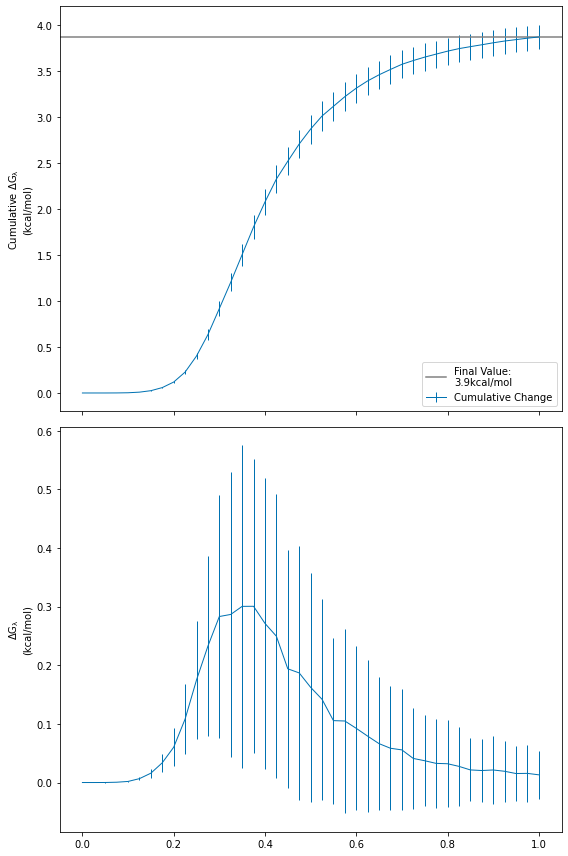

In [170]:
fig, axes = plotTI(TIcumulative, TIperWindow)
plt.savefig(f'{path}/TI_general.svg')
plt.show()

***
# Process the Bulk FEP Data
Ligand decoupling from solvent (**Step 2.4**)

In [132]:
path=f'{root}/AFEP-Bulk/output/'
filename='*.fepout' #This can be a regex pattern if you have more than one fepout file

fepoutFiles = glob(path+filename)


In [133]:
fepoutFiles = glob(path+filename) #Resolve any naming regular expressions
u_nk, _ = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ) #u_nk stores the fep data
perWindow, cumulative = doEstimation(u_nk) #Run the BAR estimator on the fep data
forward, forward_error, backward, backward_error = doConvergence(u_nk) #Used later in the convergence plot

dG_bulk = np.round(cumulative.BAR.f.iloc[-1]*RT, 1)
error_bulk = np.round(cumulative.BAR.errors.iloc[-1]*RT, 1)
changeAndError = f'\u0394G<sub>bulk</sub> = {dG_site}\u00B1{error_site} kcal/mol'
Markdown('<font size=5>{}</font><br/>'.format(changeAndError))

Decorrelating samples. Flag='True'


<font size=5>ΔG<sub>bulk</sub> = 14.9±0.1 kcal/mol</font><br/>

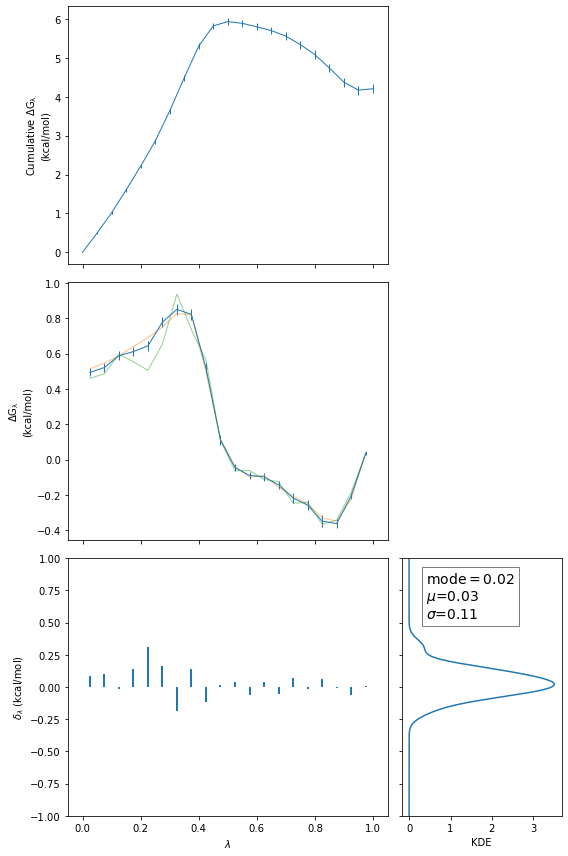

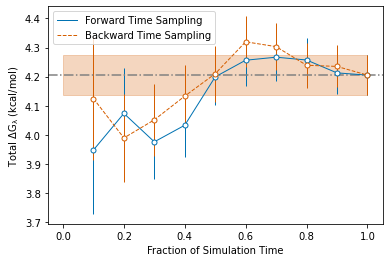

In [134]:
width = 8
height = 4
fig, axes = plotGeneral(cumulative, perWindow, RT, width=width, height=height, PDFtype='KDE')
plt.savefig(f'{path}bulk_generalFigures.pdf')
#plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()

fig, convAx = plt.subplots(1,1)
convAx = convergencePlot(convAx, forward*RT, forward_error*RT, backward*RT, backward_error*RT)
convAx.set(xlabel='Fraction of Simulation Time', ylabel=r'Total $\rm\Delta G_{\lambda}$ (kcal/mol)')
fig.set_figwidth(width*3/4)
fig.set_figheight(height)
convAx.legend()
plt.savefig(f'{path}bulk_convergence.svg')
plt.show()

***
# Calculate the Volumetric Restraint Contribution
**Step 2.5**


In [135]:
molar = 1660 #cubic angstroms per particle in a one molar solution
dG_V = np.round(-RT*np.log(4/3*sp.pi*radius**3/molar), 1)
error_V = 0

In [136]:
change = f'\u0394G<sub>V</sub> = {np.round(dG_V, 1)} kcal/mol'
Markdown('<font size=5>{}</font><br/>'.format(change))

<font size=5>ΔG<sub>V</sub> = 1.6 kcal/mol</font><br/>

***
# Calculate the Binding Free Energy
**Step 2.5**

In [137]:
dG_binding = dG_bulk + dG_V + dG_DBC - dG_site
error_binding = np.sqrt(np.mean(np.array([error_bulk, error_V, error_site, error_DBC])**2))

In [138]:
changeAndError = f'\u0394G<sub>binding</sub> = {np.round(dG_binding, 1)}\u00B1{np.round(error_binding, 1)} kcal/mol'
Markdown('<font size=5>{}</font><br/>'.format(changeAndError))

<font size=5>ΔG<sub>binding</sub> = -5.2±0.1 kcal/mol</font><br/>

# Estimate the titration curve
The Hill coefficient is 1 (no cooperativity), the dissociation constant is given by EXP(dG_binding/RT)

In [155]:
def hill(n, K, L):
    return L**n/(K**n+L**n)

def Ka(dG, RT):
    return np.exp(dG/RT)*1000

In [141]:
concentrations = np.logspace(-3,2,1000)

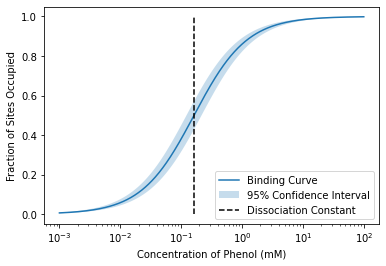

In [159]:
n=1
plt.plot(concentrations, hill(n, Ka(dG_binding, RT), concentrations), label='Binding Curve')
plt.fill_between(concentrations, hill(n, Ka(dG_binding-error_binding*1.96, RT), concentrations), hill(n, Ka(dG_binding+error_binding*1.96, RT), concentrations), alpha=0.25, label='95% Confidence Interval')
plt.xscale('log')
plt.xlabel('Concentration of Phenol (mM)')
plt.ylabel('Fraction of Sites Occupied')
plt.vlines(K, 0,1, linestyles='dashed', color='black', label='Dissociation Constant')
plt.legend(loc='lower right')

plt.savefig(f'{root}/titration_curve.svg')
plt.show()